In [1]:
import pickle
import numpy as np
from numpy.random import choice
import pandas as pd
from collections import defaultdict
from typing import Dict
import seaborn as sns
import matplotlib.pyplot as plt
import time
import sys

# Python files with environment and helpers
from shared import actions, list_actions, rewards, exits, start
from helpers import create_grid, visualize_policy

In [2]:
%%capture
from tqdm.notebook import trange, tqdm
tqdm().pandas()

# Preparation
We should first load our $\pi_*$ policy from the previous exercise.<br>
I accomplish this through a `policy.pickle` file.<br>
If you don't have this file please run the previous notebook first!!

In [3]:
def create_random_policy(rewards, list_actions):
    random_policy = np.zeros([rewards.shape[0], rewards.shape[1], len(list_actions)])
    for y in random_policy:
        for x in y:
            rand_col = choice(range(4), 1, replace=False)[0]
            x[rand_col] = 1
    
    return random_policy

In [4]:
policy_file = open('policy.pickle', 'rb')     
optimal_policy = pickle.load(policy_file)
random_policy = create_random_policy(rewards, list_actions)
policy_file.close()

In [5]:
print("Visualize random policy:")
visualize_policy(random_policy, actions)

Visualize random policy:


0     1     2     3
0   DOWN    UP  DOWN  DOWN
1  RIGHT  LEFT    UP  LEFT
2   DOWN  LEFT  DOWN    UP
3     UP  LEFT  DOWN  DOWN

In [6]:
print("Visualize optimal policy:")
visualize_policy(optimal_policy, actions)

Visualize optimal policy:


0   1   2   3
0  UP  UP  UP  UP
1  UP  UP  UP  UP
2  UP  UP  UP  UP
3  UP  UP  UP  UP

In [7]:
def step(state, action):
    next_state = get_next_position(state, action, rewards)
    reward = rewards[next_state]
    done = next_state in exits
    return next_state, reward, done

In [8]:
def get_action(desired_action: str, actions: Dict[str, tuple], chosen_prob = .7):
    # Probability for all actions - the probability of the one you chose
    remaining_actions = list(set(actions.keys())- {desired_action})
    remaining_prob = round((1 - chosen_prob) / len(remaining_actions), 1)
    remaining_probabilities = [remaining_prob for _ in range(0, len(remaining_actions))]
    
    return choice(
        [desired_action, *remaining_actions],
        replace=False,
        p=[chosen_prob, *remaining_probabilities]
    )

def get_next_position(location, action_name, grid):
    """Calculate next position based on the action and the current position."""
    game_height, game_width = grid.shape
    y, x = location
    next_y, next_x = actions[action_name]
    next_x += x
    next_y += y
    
    # Check if the new position is within our game grid
    if (next_x >= 0 and next_x < game_width):
        if (next_y >= 0 and next_y < game_height):
            return (next_y, next_x)
    
    # If not in the game grid return the original location
    return location

# 1. Model-Free Prediction
De enige manier om erachter te komen hoe de wereld in elkaar zit voor mensen, is door de wereld te ervaren. We worden ouder, we maken fouten, af en toe doen we iets goed, daar krijgen we dan meestal een beloning voor. Langzaam maar zeker evolueert ons model. Deze vorm van ervaring op doen noemen we "Sampling" in het veld van Reinforcement Learning. Om een value-function te krijgen zonder gegeven model van de wereld kunnen we dit idee toepassen.

# 1.1 Monte-Carlo Policy Evaluation
Lees h5.1 van http://incompleteideas.net/book/RLbook2020.pdf

Kijk eventueel
https://youtu.be/PnHCvfgC_ZA?list=PLqYmG7hTraZDM-OYHWgPebj2MfCFzFObQ&t=560

Hieronder zie je het pseudo-algoritme:
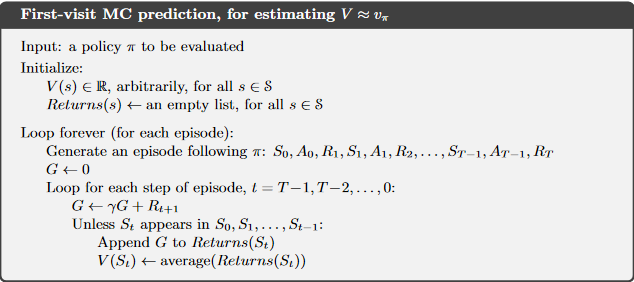

Implementeer Monte-Carlo Policy evaluation en voer deze uit op de doolhof. Evalueer daarmee twee policies met $\gamma = 0.9$ en $\gamma = 1$.<br>
$\pi_0$, de random policy. Deze doet altijd een random, legale, actie.<br>
$\pi_*$ , de optimale policy. Deze heb je de vorige opdracht al weten te bepalen met behulp van Value Iteration.
<br><br>
Lever een screenshot in waar de utilities voor elke state zichtbaar zijn na evaluatie met behulp van Monte-Carlo Policy Evaluation.

In [9]:
# Based off of dennybritz/reinforcement-learning github
def policy_eval(policy, n_episodes, start_state, discount_factor=1.0):
    grid = rewards
    returns_sum = np.zeros(grid.shape)
    returns_count = np.zeros(grid.shape)
    
    V = np.zeros(grid.shape)
    
    for i_episode in trange(1, n_episodes + 1):
        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = start_state
        for _ in range(100):
            desired_action = np.argmax(policy[state])
            action = get_action(list_actions[desired_action], actions)
            next_state, reward, done = step(state, action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # Find all states the we've visited in this episode
        # We convert each state to a tuple so that we can use it as a dict key
        states_in_episode = set([tuple(x[0]) for x in episode])
        for state in states_in_episode:
            # Find the first occurance of the state in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == state)
            # Sum up all rewards since the first occurance
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # Calculate average return for this state over all sampled episodes
            returns_sum[state] += G
            returns_count[state] += 1.0
            V[state] = returns_sum[state] / returns_count[state]

    return V

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

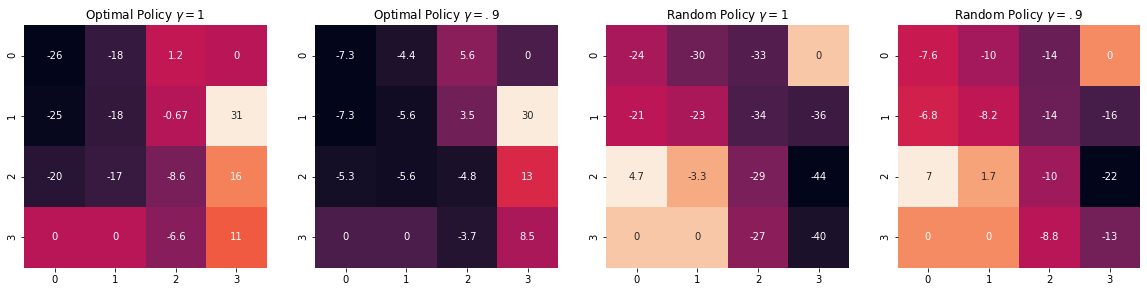

In [10]:
n_episodes = 50000
opt_policy_discount_1 = policy_eval(optimal_policy, n_episodes, start, discount_factor = 1)
opt_policy_discount_09 = policy_eval(optimal_policy, n_episodes, start, discount_factor = .9)
rand_policy_discount_1 = policy_eval(random_policy, n_episodes, start, discount_factor = 1)
rand_policy_discount_09 = policy_eval(random_policy, n_episodes, start, discount_factor = .9)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
fig.set_size_inches(20, 10)
sns.heatmap(opt_policy_discount_1, annot=True, square=True, cbar=False, ax=ax1)
sns.heatmap(opt_policy_discount_09, annot=True, square=True, cbar=False, ax=ax2)
# Change these two to a random policy v
sns.heatmap(rand_policy_discount_1, annot=True, square=True, cbar=False, ax=ax3)
sns.heatmap(rand_policy_discount_09, annot=True, square=True, cbar=False, ax=ax4)

ax1.set_title(r'Optimal Policy $\gamma = 1$')
ax2.set_title(r'Optimal Policy $\gamma = .9$')
ax3.set_title(r'Random Policy $\gamma = 1$')
ax4.set_title(r'Random Policy $\gamma = .9$')

plt.show()

## 1.2 Temporal Difference Learning
Een nadeel aan MCPE is dat je mogelijk dood gaat voordat je erachter komt dat je bijna dood ging. Een methode die dit soort problemen kan voorkomen is Temporal Difference Learning. Oftewel TD-learning.

Lees h6.1 van http://incompleteideas.net/book/RLbook2020.pdf en kijk eventueel
https://youtu.be/PnHCvfgC_ZA?list=PLqYmG7hTraZDM-OYHWgPebj2MfCFzFObQ&t=2046


Hieronder zie je het pseudo-algoritme:
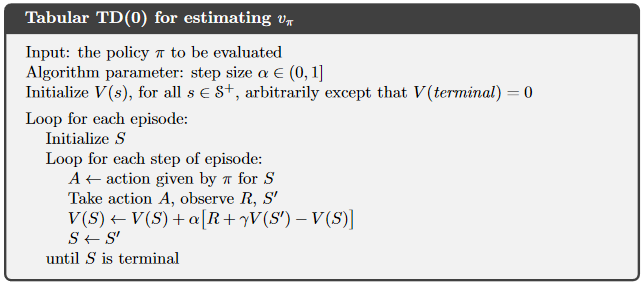

 
Implementeer TD-Learning. En voer weer met dezelfde twee policies uit met $\gamma = 0.9$ en $\gamma = 1$ als bij vraag 1.1 en voeg printscreens toe aan je verslag.

In [11]:
def tabular_td(policy, alpha, n_episodes, discount_factor = 1.0):
    grid = rewards
    V = np.random.random(grid.shape)
    for exit in exits:
        V[exit] = 0
    
    for _ in trange(n_episodes):
        # Pick an action
        state = start
        for t in range(100):
            action = np.argmax(policy[state])
            next_state, reward, done = step(state, list_actions[action])
            V[state] += alpha * (reward + discount_factor * V[next_state] - V[state])  
            state = next_state
            if done:
                break
    return V

In [12]:
opt_policy_discount_1 = tabular_td(optimal_policy, .1, n_episodes, discount_factor = 1)
opt_policy_discount_09 = tabular_td(optimal_policy, .1, n_episodes, discount_factor = .9)
rand_policy_discount_1 = tabular_td(random_policy, .1, n_episodes, discount_factor = 1)
rand_policy_discount_09 = tabular_td(random_policy, .1, n_episodes, discount_factor = .9)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
fig.set_size_inches(20, 10)
sns.heatmap(opt_policy_discount_1, annot=True, square=True, cbar=False, ax=ax1)
sns.heatmap(opt_policy_discount_09, annot=True, square=True, cbar=False, ax=ax2)
# Change these two to a random policy v
sns.heatmap(rand_policy_discount_1, annot=True, square=True, cbar=False, ax=ax3)
sns.heatmap(rand_policy_discount_09, annot=True, square=True, cbar=False, ax=ax4)

ax1.set_title(r'Optimal Policy $\gamma = 1$')
ax2.set_title(r'Optimal Policy $\gamma = .9$')
ax3.set_title(r'Random Policy $\gamma = 1$')
ax4.set_title(r'Random Policy $\gamma = .9$')

plt.show()

  0%|          | 0/50000 [00:00<?, ?it/s]

KeyboardInterrupt: 

# 2 Model-Free Control
Nu gaan we toe werken naar de laatste stap. Model-Free control. Daarvoor zijn echter twee problemen die we nog niet hebben opgelost. Onze policy evaluation algoritmes baseren de value-function met behulp van wetenschap wat de volgende state S' is gegeven dat we actie a kiezen in huidige state S. Maar deze kennis hebben we helemaal niet! In plaats daarvan kunnen we beter met q-waardes gaan werken. De Q-waarde is een mapping van states en actions naar utility.

Voor een reminder of extra uitleg zie h3.5 van http://incompleteideas.net/book/RLbook2020.pdf

Het grootste verschil is dat we niet hoeven te weten wat de volgende state is. In plaats daarvan slaan we ergens op wat het de resultaten tot dusver waren toen we in state s, actie a namen en wat daarvan de waarde was.


Dan rest ons nog één probleem. Namelijk dat we niet policy iteration of value iteration kunnen toepassen met behulp van een greedy algoritme. Dit leidt namelijk tot sub-optima. In plaats daarvan gebruiken we $\epsilon$-greedy. $\epsilon$ is een kleine waarde die representatief is voor de kans dat we exploreren, in plaats van exploiteren.

In [33]:
learning_rate = 0.1
episodes = 50000
max_steps = 2500
epsilon = 1
n_tests = 2

In [34]:
# Heavily inspired by
# https://towardsdatascience.com/reinforcement-learning-temporal-difference-sarsa-q-learning-expected-sarsa-on-python-9fecfda7467e
def epsilon_greedy(Q, epsilon, n_actions, s, train=False):
    """
    @param Q Q values state x action -> value
    @param epsilon for exploration
    @param s number of states
    @param train if true then no random actions selected
    """
    if train or np.random.rand() < epsilon:
        action = np.argmax(Q[s[0], s[1], :])
    else:
        action = np.random.randint(0, n_actions)
    return action

def init_q(state_space, actions, type="ones"):
    states_y, states_x = state_space

    if type == "ones":
        return np.ones((states_y, states_x, actions))
    elif type == "random":
        return np.random.random((states_y, states_x, actions))
    elif type == "zeros":
        return np.zeros((states_y, states_x, actions))

In [35]:
def test_agent(Q, n_tests, n_actions):
    for test in range(n_tests):
        print(f"Test #{test}")
        s = start
        done = False
        epsilon = 0
        while True:
            a = epsilon_greedy(Q, epsilon, n_actions, s, train=True)
            print(f"Chose action {list_actions[a]} for state {s}")
            s, reward, done = step(s, list_actions[a])
            if done:
                if s != (3,1):
                    print("Reached goal!")
                else:
                    print("Shit! dead x_x")
                time.sleep(3)
                break

## 2.1 On-policy first-visit Monte-Carlo Control
De conceptueel simpelste oplossing is er weer een die we ondertussen zouden moeten herkennen.

Voor meer uitleg over Monte-Carlo lees h5.4 van http://incompleteideas.net/book/RLbook2020.pdf en/of kijk
https://youtu.be/0g4j2k_Ggc4?list=PLqYmG7hTraZDM-OYHWgPebj2MfCFzFObQ&t=1421

De pseudocode voor het eerste algoritme:
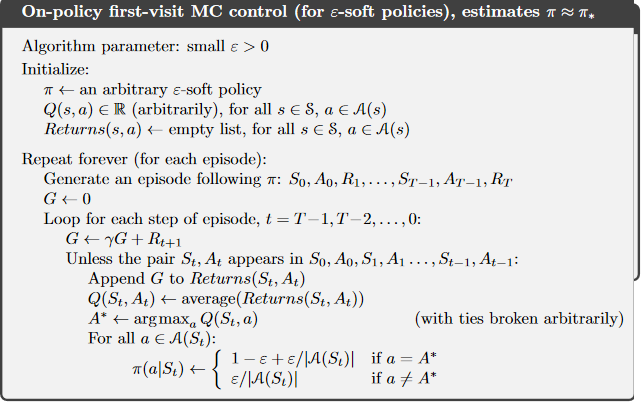

Voer nadat je deze hebt geimplementeerd je functie weer op de doolhof uit met $\gamma = 0.9$ en $\gamma = 1$     en laat visueel zien wat de uiteindelijke policy is. De policy komt terecht in wat we een Q-table noemen. Dus print deze uit bijvoorbeeld.

In [36]:
def play_episode(policy):
    episode = []
    state = start
    while True:
        desired_action = np.argmax(policy[state])
        action = get_action(list_actions[desired_action], actions)
        next_state, reward, done = step(state, action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [43]:
def first_visit_mc(policy, gamma=1, epsilon=1.0, episodes=1000):
    state_space = rewards.shape
    n_actions = len(list_actions)

    Q = init_q(state_space, n_actions, type="random")
    state_actions_count = defaultdict(int)
    returns = defaultdict(float)

    for i_episode in range(episodes):
        if i_episode % 1000 == 0:
            print(f'Playing episode {i_episode} out of {episodes}.')

        episode = play_episode(policy)
        G = 0

        # encourage exploration at start
        epsilon = max(epsilon * 0.95, 0.01)

        state_actions_in_episode = [(s, a) for (s,a,r) in episode]
        
        for t, (state, action, reward) in enumerate(episode):
            G = gamma * G + reward

            if not (state, action) in state_actions_in_episode[0:t]:
                action = list_actions.index(action)
                returns[(state, action)] += G
                state_actions_count[(state, action)] += 1
                Q[(*state,action)] = returns[(state, action)] / state_actions_count[(state, action)]

                best_action = np.argmax(Q[state])

                for a in range(n_actions): # enumerate action space
                    if a == best_action:
                        policy[state][a] = 1 - epsilon + epsilon / n_actions
                    else:
                        policy[state][a] = epsilon / n_actions
    return Q, policy

In [44]:
first_visit_Q, first_visit_policy = first_visit_mc(optimal_policy, episodes = 10000)
visualize_policy(first_visit_policy, actions)

Playing episode 0 out of 10000.
Playing episode 1000 out of 10000.
Playing episode 2000 out of 10000.
Playing episode 3000 out of 10000.
Playing episode 4000 out of 10000.
Playing episode 5000 out of 10000.
Playing episode 6000 out of 10000.
Playing episode 7000 out of 10000.
Playing episode 8000 out of 10000.
Playing episode 9000 out of 10000.


0      1      2      3
0    UP     UP  RIGHT     UP
1    UP     UP     UP     UP
2  DOWN  RIGHT   DOWN  RIGHT
3    UP     UP     UP  RIGHT

In [45]:
first_visit_Q, first_visit_policy = first_visit_mc(optimal_policy, episodes = 10000, gamma = .9)
visualize_policy(first_visit_policy, actions)

Playing episode 0 out of 10000.
Playing episode 1000 out of 10000.
Playing episode 2000 out of 10000.
Playing episode 3000 out of 10000.
Playing episode 4000 out of 10000.
Playing episode 5000 out of 10000.
Playing episode 6000 out of 10000.
Playing episode 7000 out of 10000.
Playing episode 8000 out of 10000.
Playing episode 9000 out of 10000.


0      1      2      3
0  DOWN   DOWN  RIGHT     UP
1  DOWN   DOWN     UP     UP
2  DOWN  RIGHT   LEFT   DOWN
3    UP     UP  RIGHT  RIGHT

## 2.2 SARSA
Monte-Carlo Control is nogal inefficiënt, en we zitten dus weer met dat probleem dat we hele episodes moeten draaien voordat we iets van feedback hebben. De volgende stap is weer een Temporal-Difference-learning-techniek. En is het SARSA-algoritme.

Zie daarvoor h6.4 van http://incompleteideas.net/book/RLbook2020.pdf en  
https://youtu.be/0g4j2k_Ggc4?list=PLqYmG7hTraZDM-OYHWgPebj2MfCFzFObQ&t=2690 voor extra informatie.

Implementeer SARSA for on policy control aan de hand van de volgende pseudocode:

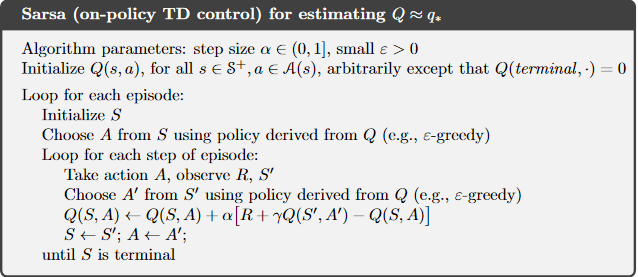

Voer net als bij de vorige opdracht uit met $\gamma = 0.9$ en $\gamma = 1$ en laat visueel zien (mag ook tekstueel, als het maar duidelijk leesbaar is) wat de uiteindelijke policy is. 

In [46]:
def sarsa(lr, gamma, epsilon, episodes, max_steps, n_tests, sarsa_max=False, test=False):
    state_space = rewards.shape
    n_actions = len(list_actions)
    
    Q = init_q(state_space, n_actions, type="ones")
    timestep_reward = np.zeros(episodes)
    for episode in range(episodes):
        total_reward = 0
        state = start
        action = epsilon_greedy(Q, epsilon, n_actions, state)
        done = False
        for t in range(max_steps + 1):
            next_state, reward, done = step(state, list_actions[action])
            total_reward += reward
            if sarsa_max:
                next_action = np.argmax(Q[next_state[0], next_state[1], :])
            else:
                next_action = epsilon_greedy(Q, epsilon, n_actions, next_state)

            if done:
                Q[(*state, action)] += lr * (reward  - Q[(*state, action)])
            else:
                Q[(*state, action)] += lr * (reward + (gamma * Q[(*next_state, next_action)]) - Q[(*state, action)])
            state, action = next_state, next_action
            if done:
                timestep_reward[episode] = total_reward
                break
        if episode % 10000 == 0:
            print(f"Episode: {episode}, total reward: {total_reward}")

    print(f"Here are the Q values:\n{Q}")
    
    if test:
        print("Testing now:")
        test_agent(Q, n_tests, n_actions)

    return timestep_reward, Q

In [47]:
_, sarsa_Q_1 = sarsa(
    learning_rate,
    1,
    epsilon,
    episodes,
    max_steps,
    n_tests,
    sarsa_max=False,
    test = True
)

Episode: 0, total reward: -30
Episode: 10000, total reward: 7
Episode: 20000, total reward: 7
Episode: 30000, total reward: 7
Episode: 40000, total reward: 7
Here are the Q values:
[[[ 8.10000000e-01  9.00000000e-01  8.10000000e-01  9.00000000e-01]
  [ 8.10000000e-01  8.00000000e-01  9.00000000e-01  9.00000000e-01]
  [ 8.10000000e-01  0.00000000e+00  8.90000000e-01  1.00000000e+00]
  [ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00]]

 [[ 9.00000000e-01  9.00000000e-01  8.10000000e-01  9.00000000e-01]
  [ 8.10000000e-01  8.00000000e-01  9.00000000e-01  0.00000000e+00]
  [ 9.00000000e-01  9.00000000e-01  8.90000000e-01  1.00000000e+00]
  [ 4.90000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00]]

 [[ 9.00000000e-01  1.00000000e+01  1.00000000e+00  1.00000000e+00]
  [ 8.10000000e-01  7.00000000e-01  9.00000000e+00  8.79900000e-01]
  [ 0.00000000e+00  4.21957195e-01  8.00000000e+00  3.81257339e-01]
  [ 0.00000000e+00  1.21396258e-01  2.22878324e-01  2.24433727e-01]

In [50]:
_, sarsa_Q_09 = sarsa(
    learning_rate,
    .9,
    epsilon,
    episodes,
    max_steps,
    n_tests,
    sarsa_max=False,
    test = True
)

Episode: 0, total reward: -30
Episode: 10000, total reward: 7
Episode: 20000, total reward: 7
Episode: 30000, total reward: 7
Episode: 40000, total reward: 7
Here are the Q values:
[[[ 0.791       0.89        0.791       0.89      ]
  [ 0.791       0.7811      0.89        0.89      ]
  [ 0.791      -0.01        0.8801      1.        ]
  [ 1.          1.          1.          1.        ]]

 [[ 0.89        0.89        0.791       0.89      ]
  [ 0.791       0.7811      0.89       -0.01      ]
  [ 0.89        0.89        0.8801      1.        ]
  [ 4.9         1.          1.          1.        ]]

 [[ 0.89       10.          1.          1.        ]
  [ 0.791       0.7         8.          0.87021881]
  [-0.01        0.25210326  6.2         0.33919219]
  [-0.01        0.07560397  0.09732161 -0.02068043]]

 [[ 1.          1.          1.          1.        ]
  [ 1.          1.          1.          1.        ]
  [ 4.58       -0.3967117  -0.405677   -0.31207781]
  [-0.13143703 -0.20152731 -0.152

In [49]:
visualize_policy(sarsa_Q_1, actions)

0     1      2      3
0  DOWN  LEFT  RIGHT     UP
1    UP  LEFT  RIGHT     UP
2  DOWN  LEFT   LEFT  RIGHT
3    UP    UP     UP     UP

In [51]:
visualize_policy(sarsa_Q_09, actions)

0     1      2     3
0  DOWN  LEFT  RIGHT    UP
1    UP  LEFT  RIGHT    UP
2  DOWN  LEFT   LEFT  LEFT
3    UP    UP     UP    UP

## 2.3 SARSAMAX a.k.a Q-Learning
Tot slot gaan we het meest bekende algoritme van reinforcement learning implementeren. De gateway naar echt goed werkende systemen voor echte problemen. Q-learning a.k.a. SARSAMAX.

Het verschil met SARSA is klein, maar in de praktijk blijkt dit algoritme wel veel beter te werken. En het was voor meneer Watkins in 1989 relatief makkelijk om te bewijzen dat dit altijd convergeert naar de optimale policy. Helemaal mooi dus

Implementeer Qlearning - SARSAMAX for off-policy control en voer net als bij de vorige opdracht uit met $\gamma = 0.9$ en $\gamma = 1$ en laat visueel zien (mag ook tekstueel, als het maar duidelijk leesbaar is) wat de uiteindelijke policy is. 

Pseudocode voor Q-learning:
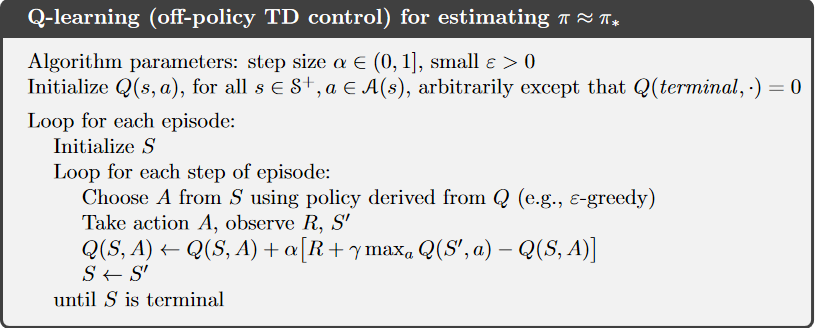

In [52]:
_, sarsa_max_Q_1 = sarsa(
    learning_rate,
    1,
    epsilon,
    episodes,
    max_steps,
    n_tests,
    sarsa_max=True,
    test=True
)

Episode: 0, total reward: -30
Episode: 10000, total reward: 7
Episode: 20000, total reward: 7
Episode: 30000, total reward: 7
Episode: 40000, total reward: 7
Here are the Q values:
[[[ 8.10000000e-01  9.00000000e-01  8.10000000e-01  9.00000000e-01]
  [ 8.10000000e-01  8.00000000e-01  9.00000000e-01  9.00000000e-01]
  [ 8.10000000e-01  0.00000000e+00  8.90000000e-01  1.00000000e+00]
  [ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00]]

 [[ 9.00000000e-01  9.00000000e-01  8.10000000e-01  9.00000000e-01]
  [ 8.10000000e-01  8.00000000e-01  9.00000000e-01  0.00000000e+00]
  [ 9.00000000e-01  9.00000000e-01  8.90000000e-01  1.00000000e+00]
  [ 4.90000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00]]

 [[ 9.00000000e-01  1.00000000e+01  1.00000000e+00  1.00000000e+00]
  [ 8.10000000e-01  7.00000000e-01  9.00000000e+00  8.79900000e-01]
  [ 0.00000000e+00  4.21957195e-01  8.00000000e+00  3.81257339e-01]
  [ 0.00000000e+00  1.21396258e-01  2.22878324e-01  2.24433727e-01]

In [54]:
_, sarsa_max_Q_09 = sarsa(
    learning_rate,
    .9,
    epsilon,
    episodes,
    max_steps,
    n_tests,
    sarsa_max=True, 
    test=True
)

Episode: 0, total reward: -30
Episode: 10000, total reward: 7
Episode: 20000, total reward: 7
Episode: 30000, total reward: 7
Episode: 40000, total reward: 7
Here are the Q values:
[[[ 0.791       0.89        0.791       0.89      ]
  [ 0.791       0.7811      0.89        0.89      ]
  [ 0.791      -0.01        0.8801      1.        ]
  [ 1.          1.          1.          1.        ]]

 [[ 0.89        0.89        0.791       0.89      ]
  [ 0.791       0.7811      0.89       -0.01      ]
  [ 0.89        0.89        0.8801      1.        ]
  [ 4.9         1.          1.          1.        ]]

 [[ 0.89       10.          1.          1.        ]
  [ 0.791       0.7         8.          0.87021881]
  [-0.01        0.25210326  6.2         0.33919219]
  [-0.01        0.07560397  0.09732161 -0.02068043]]

 [[ 1.          1.          1.          1.        ]
  [ 1.          1.          1.          1.        ]
  [ 4.58       -0.3967117  -0.405677   -0.31207781]
  [-0.13143703 -0.20152731 -0.152

In [53]:
visualize_policy(sarsa_max_Q_1, actions)

0     1      2      3
0  DOWN  LEFT  RIGHT     UP
1    UP  LEFT  RIGHT     UP
2  DOWN  LEFT   LEFT  RIGHT
3    UP    UP     UP     UP

In [55]:
visualize_policy(sarsa_max_Q_09, actions)

0     1      2     3
0  DOWN  LEFT  RIGHT    UP
1    UP  LEFT  RIGHT    UP
2  DOWN  LEFT   LEFT  LEFT
3    UP    UP     UP    UP